In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = {
            'data': torch.FloatTensor(self.data[idx]),
            'label': torch.FloatTensor([self.labels[idx]])
        }
        return sample

In [2]:
data = pd.read_csv('../ea-based-nn-ik-solver/data_3DoF-3R_N.csv')
data = np.array(data).astype(np.float32)
joints = data[:,-3:]
pos = data[:,:-3]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(joints, pos, test_size=0.2, random_state=42)

In [6]:
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)
    
    def get_network_jacobian(self, inputs, output_poses):
        # compute the Jacobian
        batch = inputs.shape[0]
        input_size = inputs.shape[1]
        output_size = output_poses.shape[1] #* self.dim_position

        # initialize a tensor to hold the Jacobian
        J = torch.zeros(batch, 1 , input_size, output_size)
        #print('J: ', J.shape)
        #print('output_size: ', output_size)
        #print('output_poses: ', output_poses.shape)
        #print('inputs: ', inputs.shape)

        t = time.time()
        for j in range(output_size):
            g = torch.autograd.grad(output_poses[:,j], 
                                    inputs, 
                                    grad_outputs=torch.ones_like(output_poses[:,j]),
                                    retain_graph=True)
            g = g[0].permute(1,0)
            g = torch.reshape(g, (batch, 1, input_size))
            J[:,:,:,j] = g
            #print('g{}: {}'.format(j, g))
        #print('g: ', g.shape)
        #print('J: ', J.shape)
        J_reshape = torch.reshape(J, (batch, -1, input_size))
        #print(J[0,:,:,0])
        #print(J[0,:,:,1])
        #print(J_reshape[0,:,:])
        #print('J_reshape: ', J_reshape.shape)

        J_reshape = J_reshape.permute(0, 2, 1) 
        #print('J_reshape: ', J_reshape.shape)
        #print(J_reshape[0,:,:])
        return J_reshape

# Training Without Jacobians

In [16]:
from torch.optim.lr_scheduler import StepLR

input_size = joints.shape[1]
hidden_sizes = [64, 128]
output_size = pos.shape[1]
learning_rate = 0.0001
num_epochs = 300

model = MLP(input_size, hidden_sizes, output_size)
criterion = nn.MSELoss()
test_criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

step_size = 40  # You can adjust this as needed
gamma = 0.5     # You can adjust this as needed
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)


In [17]:
training_total_loss = []
# Training loop
for epoch in range(num_epochs):
    for batch in train_loader:
        inputs = batch['data']
        labels = batch['label'].squeeze()
        
        # Forward pass
        outputs = model(inputs)
#         J_predicted = model.get_network_jacobian(inputs, outputs)
        
        loss = test_criterion(outputs, labels)
#         loss = combined_loss(output_poses, target_poses, J_predicted, target_jacobians, lambda_val=0.1)

        training_total_loss.append(loss.item())
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    scheduler.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the model
model.eval()
correct = 0
total = 0
total_loss = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['data']
        labels = batch['label'].squeeze()
        outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
        loss = test_criterion(outputs, labels)
        total_loss.append(loss.item())
#         correct += (predicted == labels).sum().item()
mean_loss = np.mean(np.array(total_loss))
std_loss = np.std(np.array(total_loss))
print(f'mean Test Error: {mean_loss}')
print(f'Std Test Error: {std_loss}')

model_weights_path = './model_weights/MLP_withoutJ_1.pth'
# Save the model's state_dict to the specified path
torch.save(model.state_dict(), model_weights_path)

Epoch [1/300], Loss: 0.4113
Epoch [2/300], Loss: 0.3636
Epoch [3/300], Loss: 0.2702
Epoch [4/300], Loss: 0.2076
Epoch [5/300], Loss: 0.1687
Epoch [6/300], Loss: 0.1249
Epoch [7/300], Loss: 0.1056
Epoch [8/300], Loss: 0.1217
Epoch [9/300], Loss: 0.0935
Epoch [10/300], Loss: 0.0523
Epoch [11/300], Loss: 0.0850
Epoch [12/300], Loss: 0.0632
Epoch [13/300], Loss: 0.0519
Epoch [14/300], Loss: 0.0429
Epoch [15/300], Loss: 0.0433
Epoch [16/300], Loss: 0.0302
Epoch [17/300], Loss: 0.0256
Epoch [18/300], Loss: 0.0382
Epoch [19/300], Loss: 0.0231
Epoch [20/300], Loss: 0.0192
Epoch [21/300], Loss: 0.0325
Epoch [22/300], Loss: 0.0363
Epoch [23/300], Loss: 0.0252
Epoch [24/300], Loss: 0.0286
Epoch [25/300], Loss: 0.0245
Epoch [26/300], Loss: 0.0161
Epoch [27/300], Loss: 0.0182
Epoch [28/300], Loss: 0.0164
Epoch [29/300], Loss: 0.0178
Epoch [30/300], Loss: 0.0163
Epoch [31/300], Loss: 0.0150
Epoch [32/300], Loss: 0.0199
Epoch [33/300], Loss: 0.0196
Epoch [34/300], Loss: 0.0268
Epoch [35/300], Loss: 0

Epoch [278/300], Loss: 0.0066
Epoch [279/300], Loss: 0.0070
Epoch [280/300], Loss: 0.0065
Epoch [281/300], Loss: 0.0067
Epoch [282/300], Loss: 0.0115
Epoch [283/300], Loss: 0.0097
Epoch [284/300], Loss: 0.0099
Epoch [285/300], Loss: 0.0074
Epoch [286/300], Loss: 0.0101
Epoch [287/300], Loss: 0.0089
Epoch [288/300], Loss: 0.0062
Epoch [289/300], Loss: 0.0068
Epoch [290/300], Loss: 0.0069
Epoch [291/300], Loss: 0.0114
Epoch [292/300], Loss: 0.0080
Epoch [293/300], Loss: 0.0111
Epoch [294/300], Loss: 0.0062
Epoch [295/300], Loss: 0.0132
Epoch [296/300], Loss: 0.0132
Epoch [297/300], Loss: 0.0055
Epoch [298/300], Loss: 0.0080
Epoch [299/300], Loss: 0.0068
Epoch [300/300], Loss: 0.0172
mean Test Error: 0.008826097118712607
Std Test Error: 0.002046553775149512


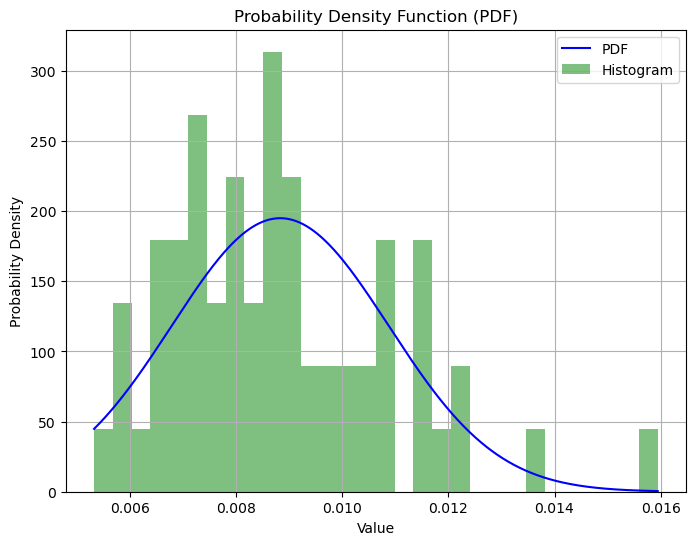

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

data = np.array(total_loss)

kde = norm(loc=np.mean(data), scale=np.std(data))
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde.pdf(x_values)

plt.figure(figsize=(8, 6))
plt.plot(x_values, pdf_values, label='PDF', color='blue')
plt.hist(data, bins=30, density=True, alpha=0.5, color='green', label='Histogram')  # Overlay a histogram for comparison
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Probability Density Function (PDF)')
plt.legend()
plt.grid(True)
plt.show()

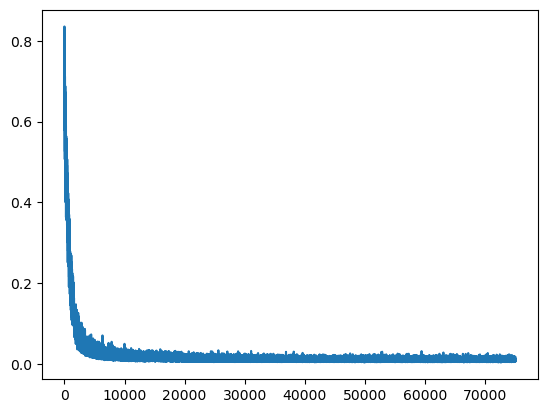

In [19]:
plt.plot(np.array(training_total_loss))

# Training with Jacobians

In [45]:


class MLP(nn.Module):

    def __init__(self, input_dim, h_sizes, output_dim):
        super().__init__()
        self.name = "MLP [{}, {}, {}]".format(str(input_dim), str(h_sizes).replace("[","").replace("]",""), str(output_dim))
        self.input_dim = input_dim
        self.h_sizes = h_sizes
        self.output_dim = output_dim     
        self.input_fc = nn.Linear(self.input_dim, self.h_sizes[0])
        self.relu_activation = nn.ReLU()      
        self.hidden_fc = nn.ModuleList()

        for i in range(len(self.h_sizes)-1):

            self.hidden_fc.append(nn.Linear(self.h_sizes[i], self.h_sizes[i+1]))

        

        self.output_fc = nn.Linear(self.h_sizes[len(self.h_sizes)-1], self.output_dim)



        

        

    def forward(self, x):
        x = self.input_fc(x)
        x = self.relu_activation(x)
        for i in range(len(self.h_sizes)-1):
            x = self.hidden_fc[i](x)
            x = self.relu_activation(x)
        x = self.output_fc(x)
        x_temp = x
        
        return x, x_temp


    def get_network_jacobian(self, inputs, output_poses):



            # compute the Jacobian

            batch = inputs.shape[0]

            input_size = inputs.shape[1]

            output_size = self.output_dim #* self.dim_position

            



            # initialize a tensor to hold the Jacobian

            J = torch.zeros(batch, 1 , input_size, output_size)

            #print('J: ', J.shape)

            #print('output_size: ', output_size)

            #print('output_poses: ', output_poses.shape)

            #print('inputs: ', inputs.shape)



            t = time.time()

            for j in range(output_size):

                g = torch.autograd.grad(output_poses[:,j], 

                                        inputs, 

                                        grad_outputs=torch.ones_like(output_poses[:,j]),

                                        retain_graph=True)

                g = g[0].permute(1,0)

                g = torch.reshape(g, (batch, 1, input_size))

                J[:,:,:,j] = g

                #print('g{}: {}'.format(j, g))





            #print('g: ', g.shape)

            #print('J: ', J.shape)



            J_reshape = torch.reshape(J, (batch, -1, self.input_dim))

            #print(J[0,:,:,0])

            #print(J[0,:,:,1])

            #print(J_reshape[0,:,:])

            #print('J_reshape: ', J_reshape.shape)



            J_reshape = J_reshape.permute(0, 2, 1) 

            #print('J_reshape: ', J_reshape.shape)

            #print(J_reshape[0,:,:])

            

            return J_reshape

In [101]:
import time 
from torch.optim.lr_scheduler import StepLR

# input_size = joints.shape[1]
# hidden_sizes = [64, 128]
# output_size = pos.shape[1]
learning_rate = 0.0001
num_epochs = 100

input_size = joints.shape[1]
hidden_sizes = [64,64,64] 
output_size = pos.shape[1]
model = MLP(input_size,
            hidden_sizes,
            output_size)
    
# model = MLP(input_size, hidden_sizes, output_size)
criterion = nn.MSELoss()
test_criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=50, gamma=0.9)

In [102]:
def combined_loss(output_poses, target_poses, pose_criterion, J_predicted, lambda_val):
    position_loss = pose_criterion(output_poses, target_poses)
    mpinv = torch.linalg.pinv(J_predicted)
    mpinv_T = torch.transpose(mpinv,1, 2)
    diff = output_poses - target_poses
    diff = diff.unsqueeze(-1)
#     print("inv = ", mpinv_T.shape)
#     print("diff = ", diff.shape)
    jacobian_loss = torch.bmm(mpinv_T,diff)
    return position_loss + lambda_val * jacobian_loss.norm()

In [103]:
training_total_loss = []
# Training loop
for epoch in range(num_epochs):
    for batch in train_loader:
        inputs = batch['data']
        inputs.requires_grad = True
        labels = batch['label'].squeeze()
        
        # Forward pass
        output, _ = model(inputs)
#         print(output.shape)
        
        J_net = model.get_network_jacobian(inputs, output)
#         print(J_net.shape)
#         print(labels.shape)
#         loss = test_criterion(outputs, labels)

        loss = combined_loss(output, labels, test_criterion, J_predicted, lambda_val=0)

        training_total_loss.append(loss.item())
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the model
model.eval()
correct = 0
total = 0
total_loss = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['data']
        labels = batch['label'].squeeze()
        outputs,_ = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
        loss = test_criterion(outputs, labels)
        total_loss.append(loss.item())
#         correct += (predicted == labels).sum().item()
mean_loss = np.mean(np.array(total_loss))
std_loss = np.std(np.array(total_loss))
print(f'mean Test Error: {mean_loss}')
print(f'Std Test Error: {std_loss}')

Epoch [1/100], Loss: 0.5406
Epoch [2/100], Loss: 0.3825
Epoch [3/100], Loss: 0.2925
Epoch [4/100], Loss: 0.1275
Epoch [5/100], Loss: 0.0955
Epoch [6/100], Loss: 0.0893
Epoch [7/100], Loss: 0.0416
Epoch [8/100], Loss: 0.0366
Epoch [9/100], Loss: 0.0561
Epoch [10/100], Loss: 0.0338
Epoch [11/100], Loss: 0.0238
Epoch [12/100], Loss: 0.0287
Epoch [13/100], Loss: 0.0236
Epoch [14/100], Loss: 0.0281
Epoch [15/100], Loss: 0.0301
Epoch [16/100], Loss: 0.0334
Epoch [17/100], Loss: 0.0311
Epoch [18/100], Loss: 0.0223
Epoch [19/100], Loss: 0.0147
Epoch [20/100], Loss: 0.0212
Epoch [21/100], Loss: 0.0168
Epoch [22/100], Loss: 0.0188
Epoch [23/100], Loss: 0.0143
Epoch [24/100], Loss: 0.0246
Epoch [25/100], Loss: 0.0196
Epoch [26/100], Loss: 0.0234
Epoch [27/100], Loss: 0.0144
Epoch [28/100], Loss: 0.0233
Epoch [29/100], Loss: 0.0159
Epoch [30/100], Loss: 0.0243
Epoch [31/100], Loss: 0.0243
Epoch [32/100], Loss: 0.0141
Epoch [33/100], Loss: 0.0107
Epoch [34/100], Loss: 0.0120
Epoch [35/100], Loss: 0

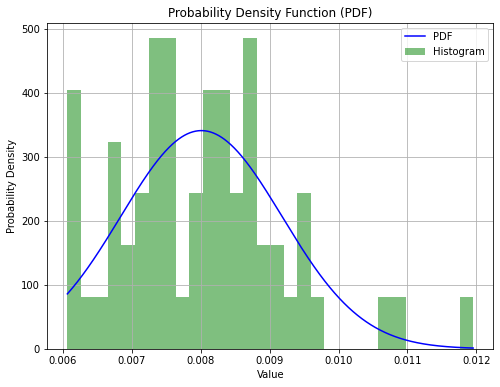

In [104]:

data = np.array(total_loss)

kde = norm(loc=np.mean(data), scale=np.std(data))
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde.pdf(x_values)

plt.figure(figsize=(8, 6))
plt.plot(x_values, pdf_values, label='PDF', color='blue')
plt.hist(data, bins=30, density=True, alpha=0.5, color='green', label='Histogram')  # Overlay a histogram for comparison
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Probability Density Function (PDF)')
plt.legend()
plt.grid(True)
plt.show()

In [105]:
model_weights_path = './model_weights/MLP_LS_1.pth'
# Save the model's state_dict to the specified path
torch.save(model.state_dict(), model_weights_path)